# Data science for business - Project

- Aries Matteo - 733410
- Beia Giacomo - 733098
- Bellini Andrea - 732699

## Project Goal

Provide a forecast on the future trend of the labor market in Lombardy
expressed in number of activated and terminated employment contracts.

The goal of the model is to predict the difference between activated and terminated contracts for a given year and month.

## Importing libraries

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from datetime import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from dateutil.relativedelta import relativedelta

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Importing datasets

The considered datasets are available on the Lombardy Region website at the following links:

[__Activated job contracts__](https://www.dati.lombardia.it/Attivit-Produttive/Rapporti-di-lavoro-attivati/qbau-cyuc)

[__Terminated job contracts__](https://www.dati.lombardia.it/Attivit-Produttive/Rapporti-di-lavoro-cessati/nwz3-p6vm)

## Datasets overview

In [3]:
# Loading and showing the first dataset

activated_job = pd.read_csv("Rapporti_di_lavoro_attivati.csv")
activated_job.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
0,09/05/2020,F,60,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA
1,12/07/2019,M,43,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
2,05/06/2013,F,20,Fabbricazione di altre apparecchiature elettri...,LICENZA MEDIA,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
3,12/03/2010,F,28,Alberghi,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERMITTENTE A TEMPO DETERMINATO,NON DEFINITO,BERGAMO,ITALIA
4,06/04/2021,F,49,Rifugi di montagna,LICENZA MEDIA,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,ITALIA


In [4]:
# Loading and showing the second dataset

terminated_job = pd.read_csv("Rapporti_di_lavoro_cessati.csv")
terminated_job.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
0,02/04/2019,M,20,Lavori di meccanica generale,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
1,08/06/2018,F,28,Fabbricazione di altre apparecchiature elettri...,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
2,02/02/2016,F,20,Fabbricazione di altre apparecchiature elettri...,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
3,12/01/2015,M,59,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
4,09/08/2017,M,61,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA


In [5]:
print('Number of elements in the Activated dataset:''%d' %(activated_job.size / activated_job.columns.size))

Number of elements in the Activated dataset:9579794


In [6]:
print('Number of elements in the Terminated dataset: %d' %(terminated_job.size / terminated_job.columns.size))

Number of elements in the Terminated dataset: 3741394


In [7]:
# Low level info about Activated dataset

activated_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9579794 entries, 0 to 9579793
Data columns (total 9 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   DATA                       object
 1   GENERE                     object
 2   ETA                        int64 
 3   SETTOREECONOMICODETTAGLIO  object
 4   TITOLOSTUDIO               object
 5   CONTRATTO                  object
 6   MODALITALAVORO             object
 7   PROVINCIAIMPRESA           object
 8   ITALIANO                   object
dtypes: int64(1), object(8)
memory usage: 657.8+ MB


In [8]:
# Low level info about Terminated dataset

terminated_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3741394 entries, 0 to 3741393
Data columns (total 9 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   DATA                       object
 1   GENERE                     object
 2   ETA                        int64 
 3   SETTOREECONOMICODETTAGLIO  object
 4   TITOLOSTUDIO               object
 5   CONTRATTO                  object
 6   MODALITALAVORO             object
 7   PROVINCIAIMPRESA           object
 8   ITALIANO                   object
dtypes: int64(1), object(8)
memory usage: 256.9+ MB


## Datasets analysis

### Activated job dataset columns description

| Name                      | Description                             |
|---------------------------|-----------------------------------------|
| DATA                      | Date in which the contract is activated |
| GENERE                    | Gender of the employee                  |
| ETA                       | Age of the employee                     |
| SETTOREECONOMICODETTAGLIO | Field of work                           |
| TITOLOSTUDIO              | Educational qualification               |
| CONTRATTO                 | Kind of job contract                    |
| MODALITALAVORO            | Working time                            |
| PROVINCIAIMPRESA          | Province where the employer is located  |
| ITALIANO                  | Nationality of the employee             |

### Terminated job dataset columns description


| Name                      | Description                             |
|---------------------------|-----------------------------------------|
| DATA                      | Date in which the contract is terminated|
| GENERE                    | Gender of the fired employee            |
| ETA                       | Age of the fired employee               |
| SETTOREECONOMICODETTAGLIO | Field of work                           |
| TITOLOSTUDIO              | Educational qualification               |
| CONTRATTO                 | Kind of job contract                    |
| MODALITALAVORO            | Working time                            |
| PROVINCIAIMPRESA          | Province where the employer is located  |
| ITALIANO                  | Nationality of the fired employee       |

### Renaming Column

By reading the values in 'ITALIANO' column in both datasets we notice that this name is not appropriate. We decide to rename it to 'NAZIONALITA', which is the right translation of 'nationality'.

In [9]:
#Renaming columns

activated_job.rename(columns={'ITALIANO':'NAZIONALITA'}, inplace=True)
terminated_job.rename(columns={'ITALIANO':'NAZIONALITA'}, inplace=True)

### Checking how many unique values for each column are in the datasets

In [10]:
#Unique values count for activated job contracts

print('\nUnique Values Count for each feature in Activated job:')
print(activated_job.nunique())


Unique Values Count for each feature in Activated job:
DATA                         2001
GENERE                          2
ETA                           103
SETTOREECONOMICODETTAGLIO    1224
TITOLOSTUDIO                   12
CONTRATTO                      54
MODALITALAVORO                  5
PROVINCIAIMPRESA               12
NAZIONALITA                   199
dtype: int64


In [11]:
#Unique values count for terminated job contracts

print('\nUnique Values Count for each feature in Terminated job:')
print(terminated_job.nunique())


Unique Values Count for each feature in Terminated job:
DATA                         2323
GENERE                          2
ETA                           103
SETTOREECONOMICODETTAGLIO    1205
TITOLOSTUDIO                   12
CONTRATTO                      54
MODALITALAVORO                  5
PROVINCIAIMPRESA               12
NAZIONALITA                   197
dtype: int64


### Checking how many null values for each column are in the datasets

In [12]:
#Null values count for activated job contracts

print('\nNull Values Count for each feature in Activated jobs:')
print(activated_job.isnull().sum())


Null Values Count for each feature in Activated jobs:
DATA                              0
GENERE                            0
ETA                               0
SETTOREECONOMICODETTAGLIO      2888
TITOLOSTUDIO                    580
CONTRATTO                         0
MODALITALAVORO               440779
PROVINCIAIMPRESA                  0
NAZIONALITA                       0
dtype: int64


On over 9 millions entries, the highest number of NaN values is 440779 on 'MODALITALAVORO' (approximately 4%). It's possible that this information was missing at the moment of data registration, since undeclared work wouldn't be registered in official datasets and there's already a category for non specified values, 'NON DEFINITO'.

Dealing with null categorical data could be difficult, since filling them with the most common value could distort the dataset and removing them would be a considerable loss. 

In [13]:
#Null values count for terminated job contracts

print('\nNull Values Count for each feature in Terminated jobs:')
print(terminated_job.isnull().sum())


Null Values Count for each feature in Terminated jobs:
DATA                            0
GENERE                          0
ETA                             0
SETTOREECONOMICODETTAGLIO    1019
TITOLOSTUDIO                  440
CONTRATTO                       0
MODALITALAVORO                  0
PROVINCIAIMPRESA                0
NAZIONALITA                     0
dtype: int64


### Checking how many duplicated values are in the datasets

In [14]:
#Duplicated values count for activated job contracts

print('\nNumber of duplicated rows in Activated:'+' %s' %activated_job.duplicated().value_counts()[1])


Number of duplicated rows in Activated: 1009435


In [15]:
#Duplicated values count for terminated job contracts

print('\nNumber of duplicated row in Terminated:'+' %s' %terminated_job.duplicated().value_counts()[1])


Number of duplicated row in Terminated: 131656


### Merging Dataset

We merge both datasets by adding the column 'TIPOLOGIA'. The possible values in this new column are 'ATTIVATO' and 'TERMINATO'. Where a value is equal to 'ATTIVATO', the row is from the Activated job dataset, whereas when a value is equal to 'TERMINATO', the row is from the Terminated job dataset.

In [16]:
#Adding new column 'TIPOLOGIA' in both datasets

activated_job['TIPOLOGIA'] = 'ATTIVATO'
terminated_job['TIPOLOGIA'] = 'TERMINATO'

In [17]:
#Merging the datasets

total = [activated_job, terminated_job]
result = pd.concat(total)
result_df = pd.DataFrame(result)

### Coverting to datetime type

'DATA' column is an object time, so we want to convert it as a datetime since we are going to use it for the models.

Initially we weren't able to cast it because one value (the one below) was exceeding the limit of representation.

In [18]:
#Showing the troublesome entry

result_df.loc[result_df['DATA'] == '12/11/2600']

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA,TIPOLOGIA
1269413,12/11/2600,M,621,Fabbricazione di imballaggi in legno,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MANTOVA,GHANA,TERMINATO


Therefore we don't convert it ('DATA' value is labeled as NaT and does not cause errors), and then we delete it.
All the other entries are converted regularly, and other three columns ('YEAR', 'MONTH' and 'DAY') are created from the updated 'DATA' column.

In [19]:
#Coverting 'DATA' column type from object to datetime, and then splitting it into three more columns:
#'YEAR', 'MONTH' and 'DAY'

result_df['DATA'] = pd.to_datetime(result_df['DATA'], errors = 'coerce', format='%d/%m/%Y')
result_df['YEAR']= result_df['DATA'].dt.year
result_df['MONTH']= result_df['DATA'].dt.month
result_df['DAY'] = result_df['DATA'].dt.day

In [20]:
#Showing datasets info

result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13321188 entries, 0 to 3741393
Data columns (total 13 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   DATA                       datetime64[ns]
 1   GENERE                     object        
 2   ETA                        int64         
 3   SETTOREECONOMICODETTAGLIO  object        
 4   TITOLOSTUDIO               object        
 5   CONTRATTO                  object        
 6   MODALITALAVORO             object        
 7   PROVINCIAIMPRESA           object        
 8   NAZIONALITA                object        
 9   TIPOLOGIA                  object        
 10  YEAR                       float64       
 11  MONTH                      float64       
 12  DAY                        float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(8)
memory usage: 1.4+ GB


In [21]:
#Showing first line of the updated dataset

result_df.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA,TIPOLOGIA,YEAR,MONTH,DAY
0,2020-05-09,F,60,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA,ATTIVATO,2020.0,5.0,9.0
1,2019-07-12,M,43,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA,ATTIVATO,2019.0,7.0,12.0
2,2013-06-05,F,20,Fabbricazione di altre apparecchiature elettri...,LICENZA MEDIA,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA,ATTIVATO,2013.0,6.0,5.0
3,2010-03-12,F,28,Alberghi,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERMITTENTE A TEMPO DETERMINATO,NON DEFINITO,BERGAMO,ITALIA,ATTIVATO,2010.0,3.0,12.0
4,2021-04-06,F,49,Rifugi di montagna,LICENZA MEDIA,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,ITALIA,ATTIVATO,2021.0,4.0,6.0


In [22]:
#Null values count for the dataset

result_df.isnull().sum()

DATA                              1
GENERE                            0
ETA                               0
SETTOREECONOMICODETTAGLIO      3907
TITOLOSTUDIO                   1020
CONTRATTO                         0
MODALITALAVORO               440779
PROVINCIAIMPRESA                  0
NAZIONALITA                       0
TIPOLOGIA                         0
YEAR                              1
MONTH                             1
DAY                               1
dtype: int64

In [23]:
#Dropping the single NaT entry

result_df.dropna(subset = ['DATA'], inplace = True)

### Graphical Analysis

### Boxplot on Year

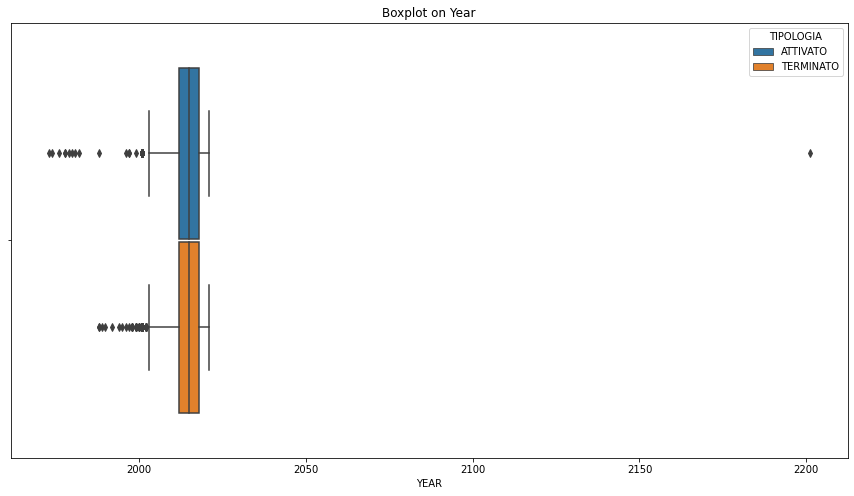

In [24]:
#Creating and showing the boxplot

ax = sb.boxplot(x=result_df['YEAR'], y=[""]*len(result_df), hue=result_df['TIPOLOGIA'])
# Workaround cause bug, y needs to be filled with dummy data
ax.set_title("Boxplot on Year")
plt.gcf().set_size_inches(15, 8)
plt.show()

From this boxplot we can notice that one entry is not only outlier, but it is clearly out of date range.

In [25]:
#Showing the troublesome entry

result_df.loc[result_df['YEAR'] > 2150]

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA,TIPOLOGIA,YEAR,MONTH,DAY
5840160,2201-09-06,M,221,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,SIRIA,ATTIVATO,2201.0,9.0,6.0


It could be easily a typing error (2201 may be 2021), but since it is only one entries on a total of more than 12 millions, we can remove it without fear of distorting the data.

In [26]:
#Removing the troublesome entry

result_df.drop(result_df[result_df['YEAR'] > 2100].index, inplace=True)

The boxplot is computed again to have a more intelligible view of it.

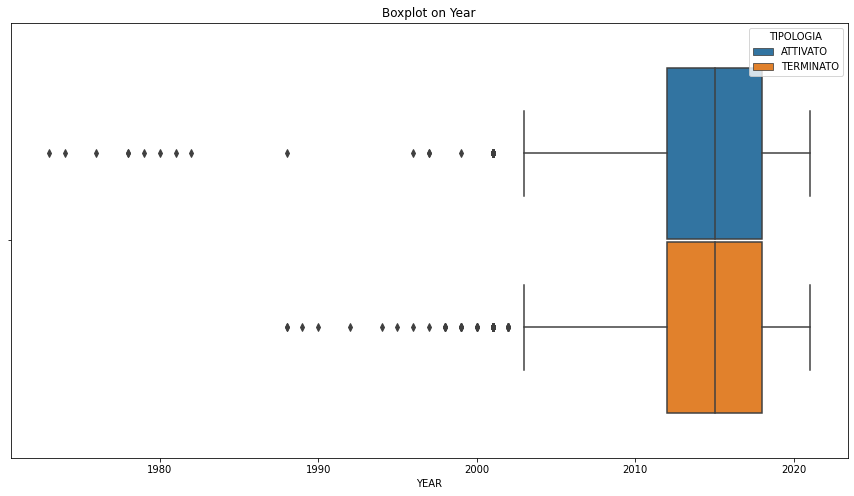

In [27]:
#Creating and showing the boxplot

ax = sb.boxplot(x=result_df['YEAR'], y=[""]*len(result_df), hue=result_df['TIPOLOGIA'])
# Workaround cause bug, y needs to be filled with dummy data
ax.set_title("Boxplot on Year")
plt.gcf().set_size_inches(15, 8)
plt.show()

Without the two entries deleted, the boxplot shows more clearly the distribution of the observations bassed on the year. IQR is between approximately 2012 and 2018.

### Countplot on Year

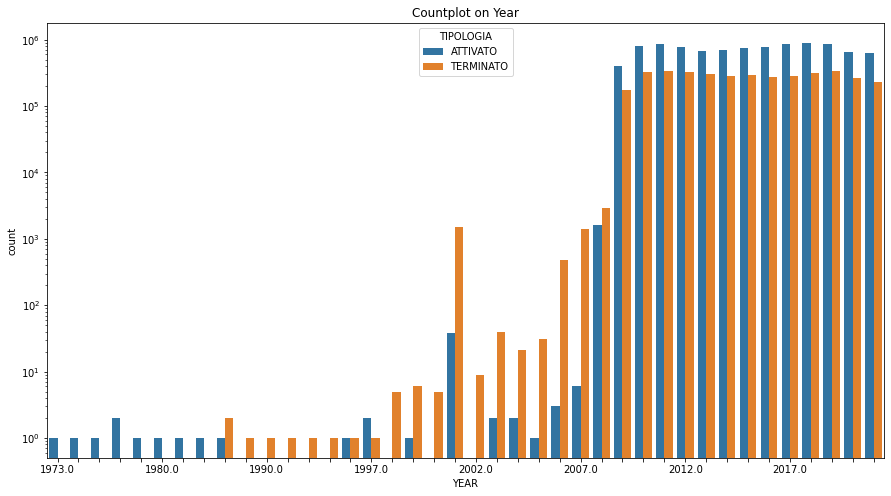

In [28]:
#Creating and showing the countplot

ax = sb.countplot(data=result_df, x='YEAR', hue = 'TIPOLOGIA')
ax.set_title("Countplot on Year")
ax.set_yscale("log")
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 5 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.gcf().set_size_inches(15, 8)
plt.show()

From this countplot we can notice that the majority of the entries are approximately between 2009 and 2021.
It's plausible that, as the plot suggests, the numbers of the Lombardy job market increased since 1980, but since all of the 1900's entries and part of the first 2000s ones consist in only 10 contracts at most, we can expect that the distribution of the data is not uniform.
This is enforced by the previous graph, obviously.

### Boxplot on Month

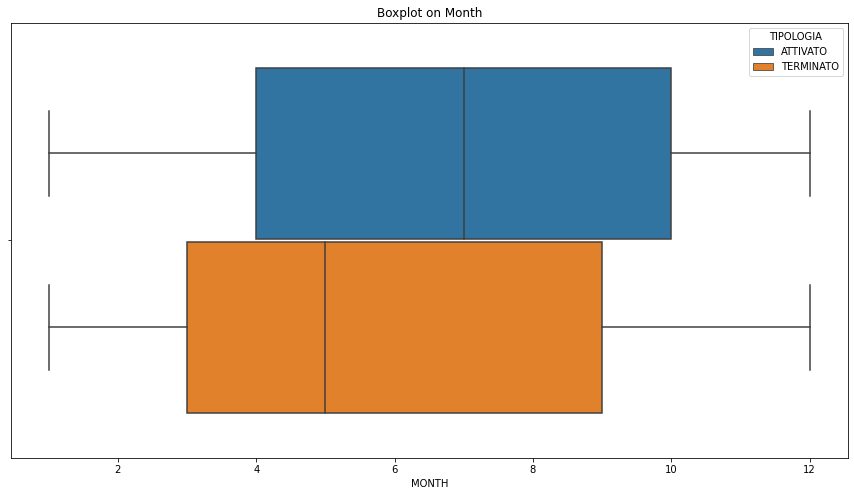

In [29]:
#Creating and showing the boxplot

ax = sb.boxplot(data=result_df, x="MONTH", y=[""]*len(result_df), hue = 'TIPOLOGIA')
# Workaround cause bug, y needs to be filled with dummy data
ax.set_title("Boxplot on Month")
plt.gcf().set_size_inches(15, 8)
plt.show()

From this boxplot we can notice that the majority of the contracts are between March-April and September-October.

### Boxplot on Day

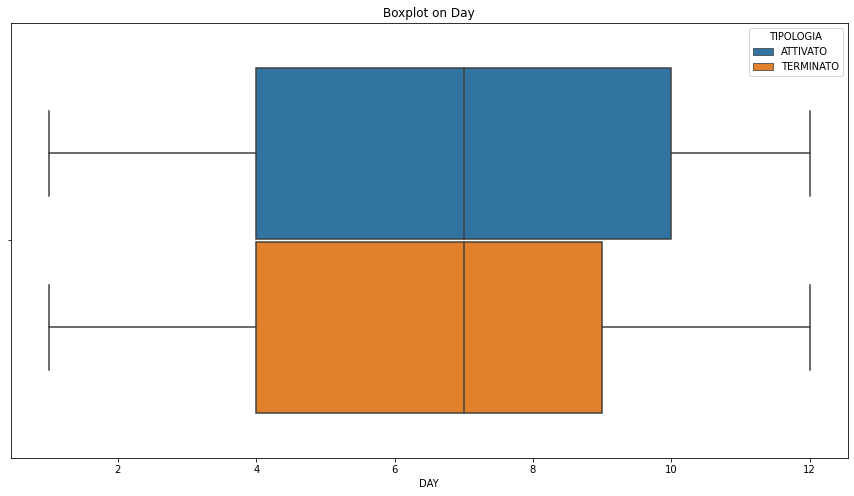

In [30]:
#Creating and showing the boxplot

ax = sb.boxplot(data=result_df, x="DAY", y=[""]*len(result_df), hue = 'TIPOLOGIA')
# Workaround cause bug, y needs to be filled with dummy data
ax.set_title("Boxplot on Day")
plt.gcf().set_size_inches(15, 8)
plt.show()

From this boxplot we can notice that all the entries of both datasets reach only the 12th of every month, suggesting that maybe the data related to the second half of every month are missing or that there was a problem of some sort during the creation of the datasets.

Since the first hypothesis would require an impossible work of filling the gaps (half of the entries would be missing), we assumed the second hypothesis as true. 
Therefore from now on we consider the datasets as if the entries are equally distributed over the days of the month.

### Countplot on Genere

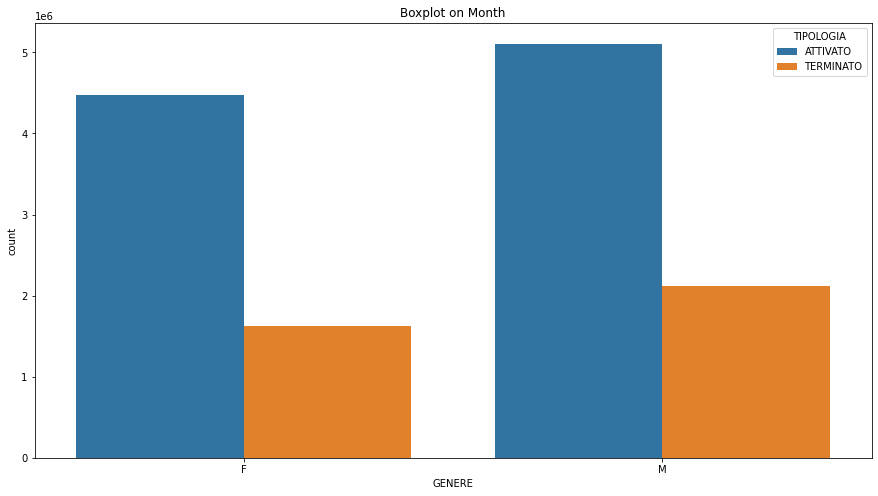

In [31]:
#Creating and showing the countplot

ax = sb.countplot(data=result_df, x="GENERE", hue="TIPOLOGIA")
ax.set_title("Boxplot on Month")
plt.gcf().set_size_inches(15, 8)
plt.show()

From this boxplot we can notice that the number of activated and termonated contracts for men and women are comparable, and in both cases the terminated ones are less than half of the activated ones.

### Boxplot GENERE vs ETA

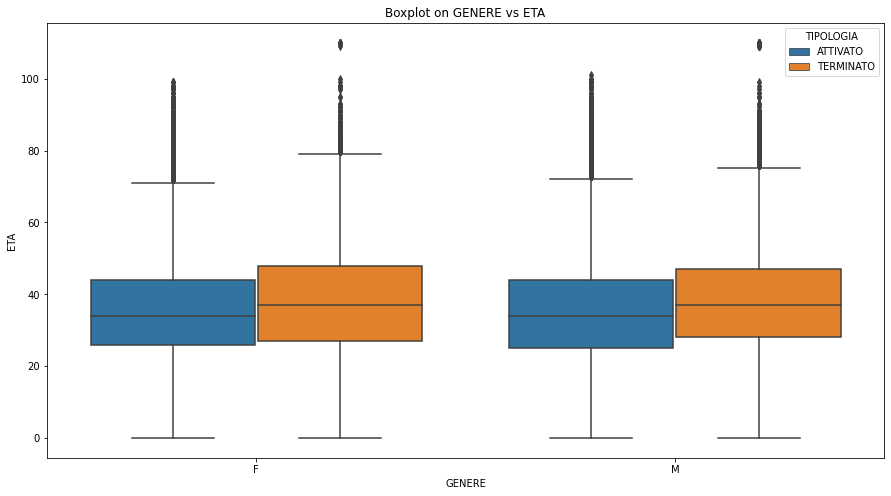

In [32]:
#Creating and showing the boxplot

ax = sb.boxplot(x="GENERE", y="ETA", hue="TIPOLOGIA", data=result_df)
ax.set_title("Boxplot on GENERE vs ETA")
plt.gcf().set_size_inches(15, 8)
plt.show()

From this boxplot we can notice that the majority of the entries are between approximately 30 and 50 years old. A considerable part of the outliers are probably errors in data registration, since it's impossible that over 90's people are still in working age.

### Countplot on ETA

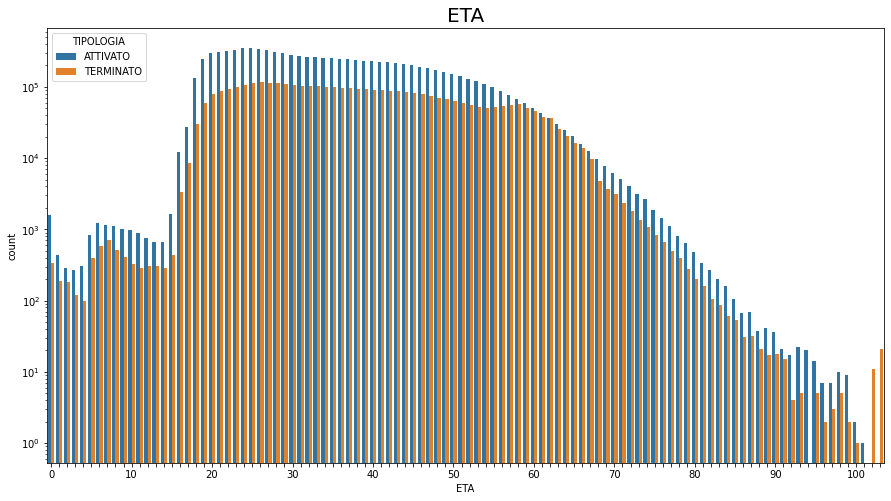

In [33]:
#Creating and showing the countplot

ax = sb.countplot(data=result_df, x="ETA", hue="TIPOLOGIA")
ax.set_yscale("log")
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.gcf().set_size_inches(15, 8)
ax.set_title("ETA", fontsize = 20)
plt.show()

From this countplot we can understand better the distribution of the feature 'ETA'. It's clear that also people under 16 years old cannot work legally, so their age are probably registration errors as well.

### Barplot on SETTOREECONOMICODETTAGLIO on Activated job contracts

'SETTOREECONOMICODETTAGLIO' contains 1224 unique values, therefore we will show the first 20 most fequent unique values for plot clearness.

In [34]:
#Selecting only the first 20 most frequent unique values

sr = activated_job.groupby('SETTOREECONOMICODETTAGLIO').size().sort_values(ascending=False)[:20]

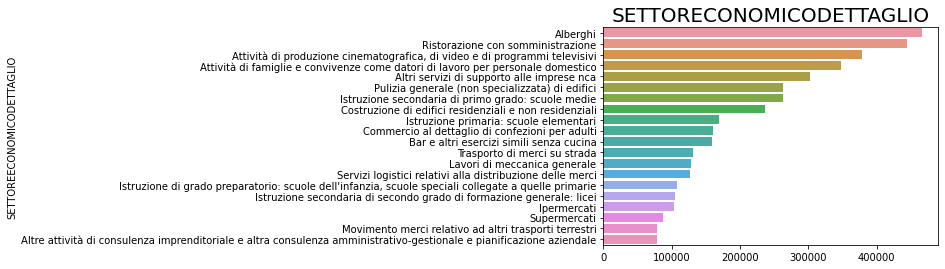

In [35]:
#Creating and showing the barplot

ax = sb.barplot(x=sr.values, y=sr.index)
ax.set_title("SETTORECONOMICODETTAGLIO", fontsize = 20)
plt.show()

### Barplot on SETTOREECONOMICODETTAGLIO on Terminated job contracts

In [36]:
#Selecting only the first 20 most frequent unique values

sr = terminated_job.groupby('SETTOREECONOMICODETTAGLIO').size().sort_values(ascending=False)[:20]

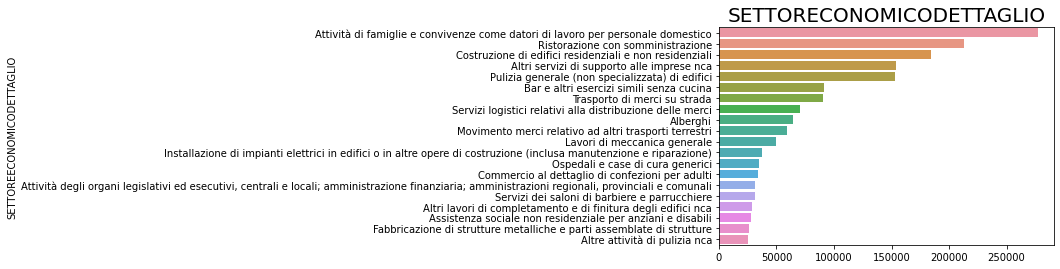

In [37]:
#Creating and showing the barplot

ax = sb.barplot(x=sr.values, y=sr.index) 
ax.set_title("SETTORECONOMICODETTAGLIO", fontsize = 20)
plt.show()

### Countplot on TITOLOSTUDIO

In [38]:
#Encoding the category for plot clearness

le_class = preprocessing.LabelEncoder()
le_class.fit(result_df['TITOLOSTUDIO'])

result_df['TITOLOSTUDIO'] = le_class.transform(result_df['TITOLOSTUDIO'])

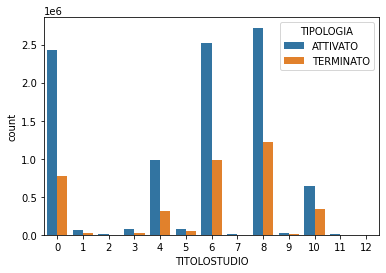

0  : DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA
1  : DIPLOMA DI SPECIALIZZAZIONE
2  : DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO
3  : DIPLOMA UNIVERSITARIO
4  : LAUREA - Vecchio o nuovo ordinamento
5  : LICENZA ELEMENTARE
6  : LICENZA MEDIA
7  : MASTER UNIVERSITARIO DI PRIMO LIVELLO
8  : NESSUN TITOLO DI STUDIO
9  : TITOLO DI DOTTORE DI RICERCA
10 : TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()
11 : TITOLO DI STUDIO POST-LAUREA
12 : nan


In [39]:
#Creating and showing the countplot

ax = sb.countplot(data=result_df, x="TITOLOSTUDIO", hue='TIPOLOGIA')
plt.show()

maxV = result_df['TITOLOSTUDIO'].max()
for v in range(0, maxV+1):
    if (v < 10):
        print(str(v) +'  : '+ le_class.inverse_transform([v])[0])
    else:
        print(str(v) +' : '+ str(le_class.inverse_transform([v])[0]))

From this countplot we can notice that the top three study title (in order) are 'NESSUN TITOLO DI STUDIO', 'LICENZIA MEDIA'  and DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CHE PERMETTE L'ACCESSO ALLUNIVERSITA'. 'LAUREA - Vecchio o nuovo ordinamento' is just the fourth one.

### Barplot on CONTRATTO Activated job contracts

'CONTRATTO' contains 54 unique values, therefore we will show the first 10 most fequent unique values for plot clearness.

In [40]:
#Selecting only the first 10 most frequent unique values

sr = activated_job.groupby('CONTRATTO').size().sort_values(ascending=False)[:10] 

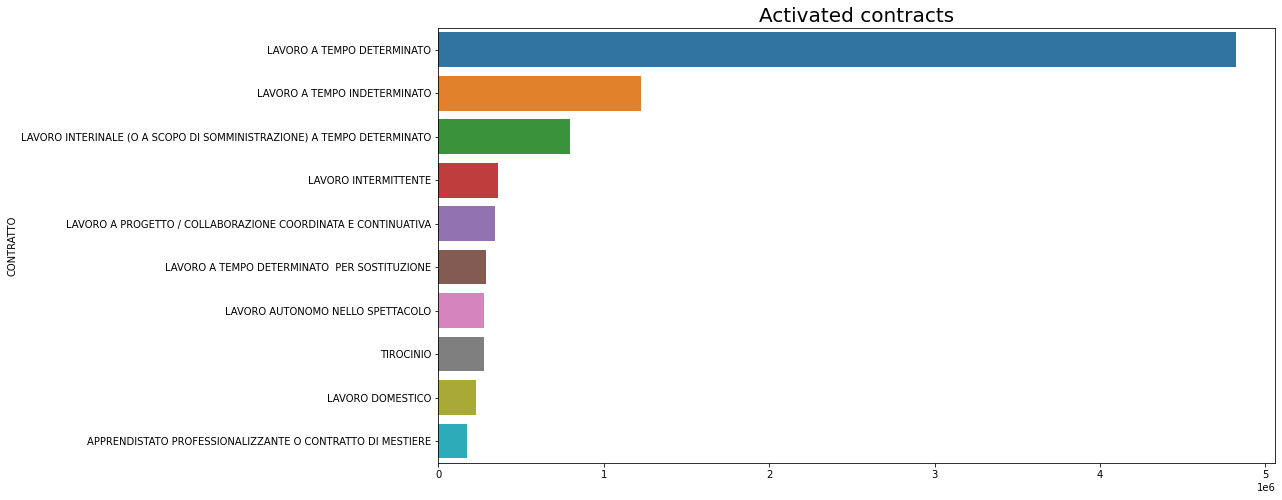

In [41]:
#Creating and showing the barplot

ax = sb.barplot(x=sr.values, y=sr.index)
ax.set_title("Activated contracts", fontsize="20")
plt.gcf().set_size_inches(15, 8)
plt.show()

From this barplot we can notice that the most activated job contract is by far 'LAVORO A TEMPO DETERMINATO'.

### Barplot on CONTRATTO Terminated job contracts

In [42]:
#Selecting only the first 10 most frequent unique values

sr = terminated_job.groupby('CONTRATTO').size().sort_values(ascending=False)[:10] #Show only first 10

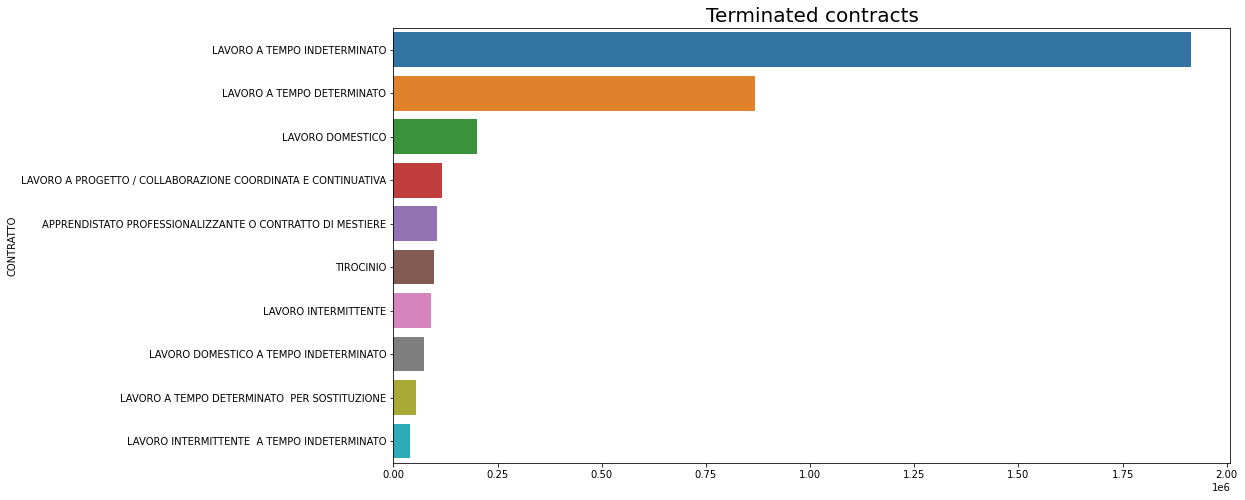

In [43]:
#Creating and showing the barplot

ax = sb.barplot(x=sr.values, y=sr.index)
ax.set_title("Terminated contracts", fontsize="20")
plt.gcf().set_size_inches(15, 8)

plt.show()

From this barplot we can notice that the most terminated job contract by far is 'LAVORO A TEMPO INDETERMINATO'.

### Countplot on MODALITALAVORO

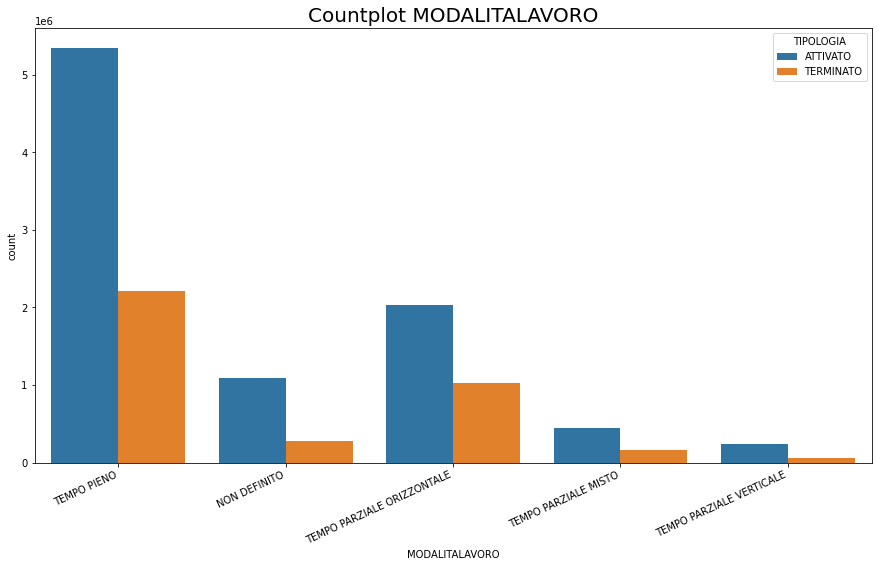

In [44]:
#Creating and showing the countplot


ax = sb.countplot(data=result_df, x="MODALITALAVORO", hue="TIPOLOGIA")
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")
ax.set_title("Countplot MODALITALAVORO", fontsize="20")
plt.gcf().set_size_inches(15, 8)
plt.show()

From this barplot we can notice that the most frequent type of work is 'TEMPO PIENO', both activated and terminated'.

### Countplot on PROVINCIAIMPRESA

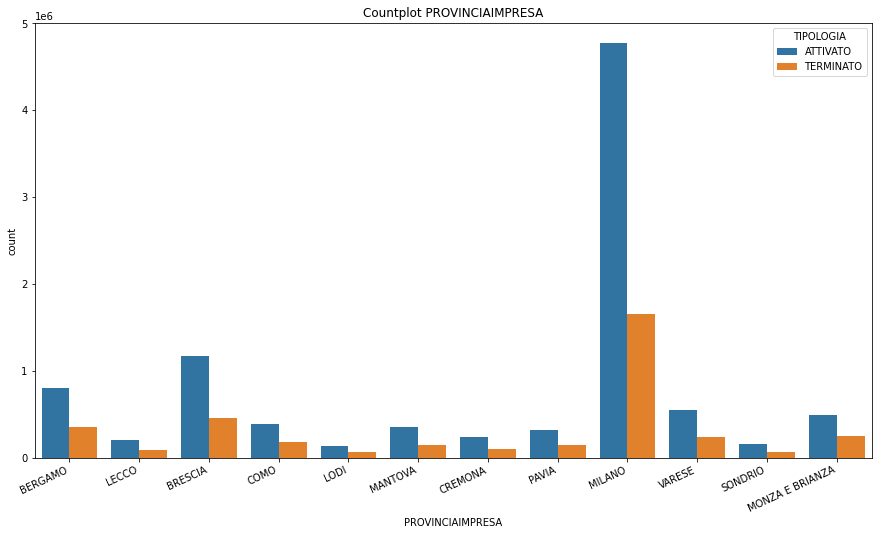

In [45]:
#Creating and showing the countplot


ax = sb.countplot(data=result_df, x="PROVINCIAIMPRESA", hue="TIPOLOGIA")
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")
ax.set_title("Countplot PROVINCIAIMPRESA")
plt.gcf().set_size_inches(15, 8)
plt.show()

From this barplot we can notice that the first province for both activated and terminated job contracts is Milan.

### Barplot on NAZIONALITA Activated job contracts

'NAZIONALITA' contains 199 unique values in Activated job contract dataset, therefore we will show the first 20 most fequent unique values for plot clearness.

In [46]:
#Selecting only the first 10 most frequent unique values

sr = activated_job.groupby('NAZIONALITA').size().sort_values(ascending=False)[:10]

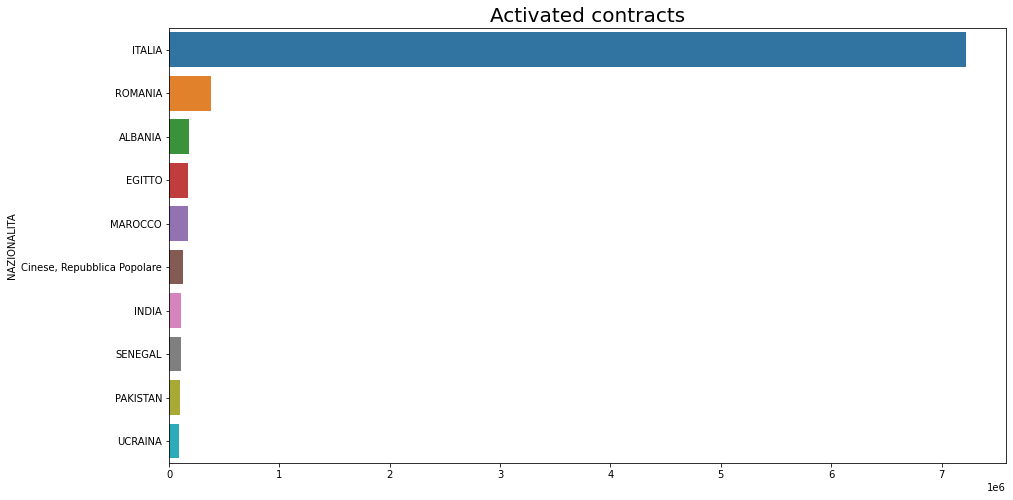

In [47]:
#Creating and showing the barplot

ax = sb.barplot(x=sr.values, y=sr.index)
ax.set_title("Activated contracts", fontsize="20")
plt.gcf().set_size_inches(15, 8)

From this barplot wee can notice that the first nationality for activated job contracts is Italy.

### Barplot on NAZIONALITA Terminated job contracts

'NAZIONALITA' contains 197 unique values in Terminated job contract dataset, therefore we will show the first 20 most fequent unique values for plot clearness.

In [48]:
#Selecting only the first 10 most frequent unique values

sr = terminated_job.groupby('NAZIONALITA').size().sort_values(ascending=False)[:10]

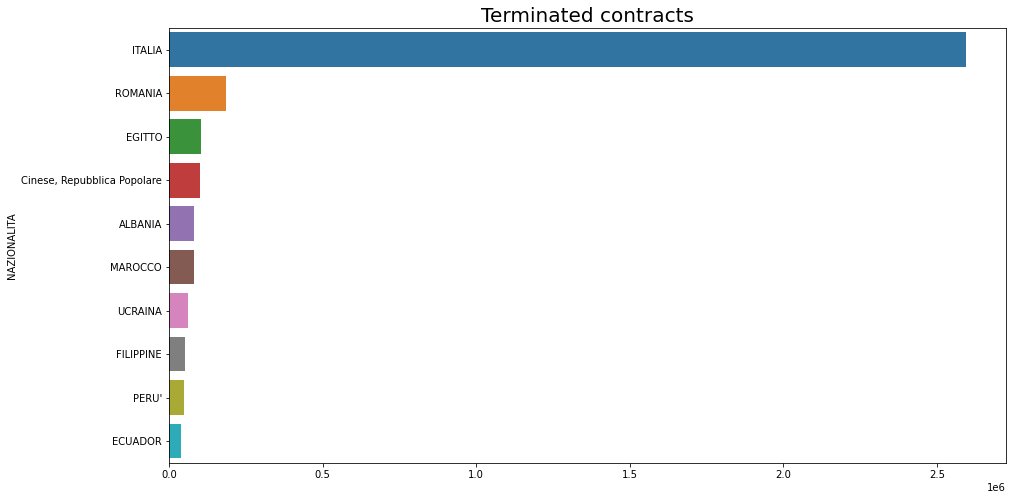

In [49]:
#Creating and showing the barplot

ax = sb.barplot(x=sr.values, y=sr.index)
ax.set_title("Terminated contracts", fontsize="20")
plt.gcf().set_size_inches(15, 8)

From this barplot wee can notice that the first nationality for terminated job contracts is Italy.

## Project goal

The main goal of this project is to provide a prevision on future trends of the job market in Lombardy, expressed in number of activated and terminated job contracts.
The model aim will be to predict the total number of contract for a specific year and month. 

Since our datasets contain data related to activated and terminated contracts we can understand if there is:
- a positive trend, more activated than terminated contracts;
- a negative trend, more terminated than activated, or;
- a costant trend, same number of contracts activated and terminated 

## Chosen Model

Basing on our goal, we can understand that we have to find a specific number of contracts over a time period. Therefore we have to define a model able to predict Time Series.

Models for time series data can have many forms, in particular linear model offers semplicity in understanding and implementation. The two most popular linear time series models are Autoregressive(AR) and Moving Average(MA) models. These models can be effectively combined together to form a general and useful class of time series models the model ARMA or also other models such as ARIMA, ARFIMA or SARIMA.

In AR(p) model the future value of a variable is assumed to be a linear combination of p past observations and a random error together with a constant
term

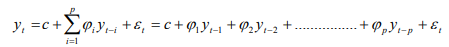

A moving average is a time series constructed by taking averages of several sequential values of another time series. MA(q) model uses past
errors as the explanatory variables.

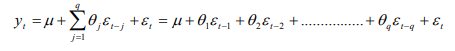

To determine a proper model for a given time series data, it is necessary to carry out the ACF and PACF analysis. These statistical measures reflect how the observations in a time series are related to each other. 

The ARMA models, described above can only be used for stationary time series data. However in practice, many time series show non-stationary behavior. Time series, which contain trend and seasonal patterns, are non-stationary in nature. 

In ARIMA models a non-stationary time series is made stationary by applying finite differencing of the data points.

The ARIMA model is for non-seasonal non-stationary data. In SARIMA seasonal differencing of appropriate order is used to remove non-stationarity from the series.

## Dataset Manipulation

Before carrying out the analysis and defining the model, we have to manipulate to original data adn create an appropriated dataframe.

In [50]:
activated_job = result_df[result_df['TIPOLOGIA'] == 'ATTIVATO']
activated_job = activated_job[['YEAR', 'MONTH', 'DAY']].copy()

terminated_job = result_df[result_df['TIPOLOGIA'] == 'TERMINATO']
terminated_job = terminated_job[['YEAR', 'MONTH', 'DAY']].copy()

First, we divide the activated and terminated contracts and the we reduce the dimension of the dataframes by selecting only year, month and day.

In [51]:
activated_job = activated_job.groupby(['YEAR', 'MONTH']).size().reset_index(name='events')
terminated_job = terminated_job.groupby(['YEAR', 'MONTH']).size().reset_index(name='events')

Grouping row with same year and month, we create a new column 'events' that represents the amount of activated/terminated contracts for the related date

In [52]:
analysis_df = activated_job.copy()
analysis_df['events'] = activated_job['events'] - terminated_job['events']

The analysis dataframe is composed by the date (year and month) and the number of activated contracts - terminated contract. 
In this way we identify the montly trend of contracts.

Since the dataset presents outliers and befor the year 2008 the amount of information is low, we reduce the date range of the df.

`analysis_df = analysis_df[(analysis_df['YEAR'] < 2021) & (analysis_df['YEAR'] > 2009)]`

Year and month column have to be converted into a single column that we will use later to train and test the model. Therefore the comlumn date is created in the following way:

`analysis_df['DATA'] = analysis_df['YEAR'].astype(int).astype(str) + '-' + analysis_df['MONTH'].astype(int).astype(str) + '-01'`

`analysis_df['DATA'] = pd.to_datetime(analysis_df['DATA'])`

Before performing the analysis we have to create the train set and the test set

`X = analysis_df.values`

`size = int(len(X) * 0.66)`

`train, test = X[0:size], X[size:len(X)]`

## Stationarity - Dickey-Fuller test

This is one of the statistical tests for checking stationarity. p-value must be less than 0,05 to consider the series stationary

In [53]:
#Check Stationarity of time series

def test_stationarity(timeseries):
    #Convert numpy array to pandas serie
    if type(timeseries) is np.ndarray:
        df_timeseries = pd.Series(timeseries) 
        
    try:
        #Determing rolling statistics
        rolmean = df_timeseries.rolling(window=12).mean()
        rolstd = df_timeseries.rolling(window=12).std()

        #Plot rolling statistics
        orig = plt.plot(timeseries, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)

        #Perform Dickey-Fuller test
        print('Results of Dickey-Fuller Test:')

        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
    
        return dftest, dfoutput
    except Exception as message:
        print(f"Impossible to compute the stationarity of your TS: {message}")
        return None, None

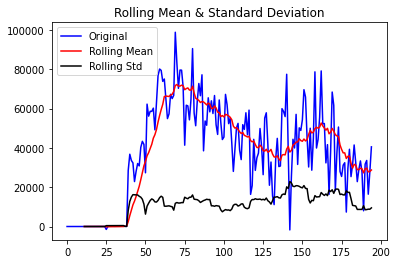

Results of Dickey-Fuller Test:


Test Statistic                  -2.405720
p-value                          0.140128
#Lags Used                      15.000000
Number of Observations Used    179.000000
Critical Value (1%)             -3.467420
Critical Value (5%)             -2.877826
Critical Value (10%)            -2.575452
dtype: float64

In [54]:
#Showing Stationarity for Total DF

dftest, dfoutput = test_stationarity(analysis_df.events.values)
dfoutput

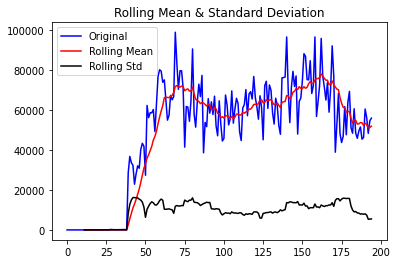

Results of Dickey-Fuller Test:


Test Statistic                  -2.244304
p-value                          0.190560
#Lags Used                      14.000000
Number of Observations Used    180.000000
Critical Value (1%)             -3.467211
Critical Value (5%)             -2.877735
Critical Value (10%)            -2.575403
dtype: float64

In [55]:
#Showing Stationarity for Activated Job

dftest, dfoutput = test_stationarity(activated_job.events.values)
dfoutput

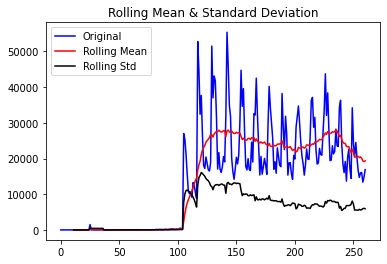

Results of Dickey-Fuller Test:


Test Statistic                  -1.511885
p-value                          0.527624
#Lags Used                      15.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64

In [56]:
#Showing Stationarity for Terminated Job

dftest, dfoutput = test_stationarity(terminated_job.events.values)
dfoutput

Test statistic is greater than critical values, mean and standard deviation slightly decrease over time.

Every dataframe considered for the analysis presents a non-stationary behaviour. Therefore we cannot use ARMA model, since it uses stationary data. Seasonality analysis has to be carryed out in order to understand if there are seasonality in the data.

## Seasonality

Seasonality in time-series data refers to a pattern that occurs at a regular interval. This is different from regular cyclic trends, such as the rise and fall of stock prices, that re-occur regularly but don’t have a fixed period.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

In [57]:
# Check Seasonality of the Time Series

def test_seasonality(temp_df):
    
    # Dataframe manipulation
    df = temp_df.copy()
    df = df[(df['YEAR'] < 2021) & (df['YEAR'] > 2009)]
    df['DATA'] = df['YEAR'].astype(int).astype(str) + '-' + df['MONTH'].astype(int).astype(str) + '-01'
    df['DATA'] = pd.to_datetime(df['DATA'])
    df = df.drop(columns = ['YEAR', 'MONTH'])
    df.set_index('DATA', inplace=True)
    
    # Computing Trend, Seasonal and Resid of the time series 
    decompose_result_mult = seasonal_decompose(df, model="additive")

    trend = decompose_result_mult.trend
    seasonal = decompose_result_mult.seasonal
    residual = decompose_result_mult.resid

    # Plotting seasonality information
    decompose_result_mult.plot();

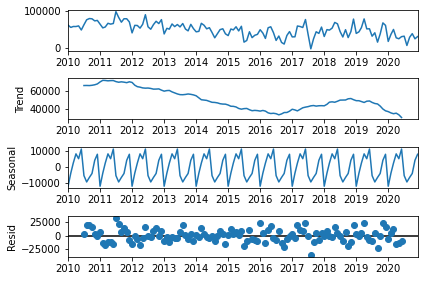

In [58]:
# Computing Stationarity for Total df

test_seasonality(analysis_df)

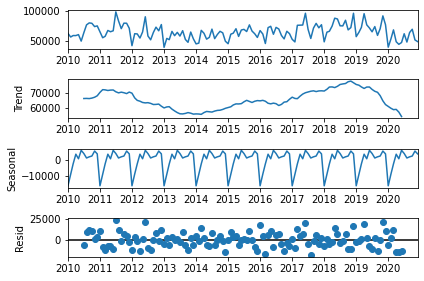

In [59]:
# Computing Stationarity for Activated job

test_seasonality(activated_job)

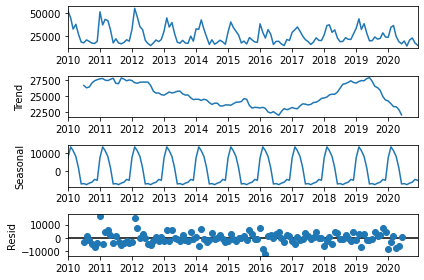

In [60]:
# Computing Stationarity for Terminated Job

test_seasonality(terminated_job)

## Performing analysis

### Showing Time Series

In [61]:
# Plotting DF values over time underlying each year

def plot_df_values(temp_df, title):
    
    #Df Manipulation
    df = temp_df.copy()
    df = df[(df['YEAR'] < 2021) & (df['YEAR'] > 2009)]
    df['DATA'] = df['YEAR'].astype(int).astype(str) + '-' + df['MONTH'].astype(int).astype(str) + '-01'
    df['DATA'] = pd.to_datetime(df['DATA'])
    
    # Plotting Data
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(x='DATA', y='events', data = df)
    chart.set_title('Data for '+title)
    
    for v in df['YEAR'].unique():
        tempDate = str(int(v))+'-01-01'
        correctDate = datetime.strptime(tempDate, '%Y-%m-%d').date()
        chart.axvline(x=correctDate, color='black', linestyle='--')

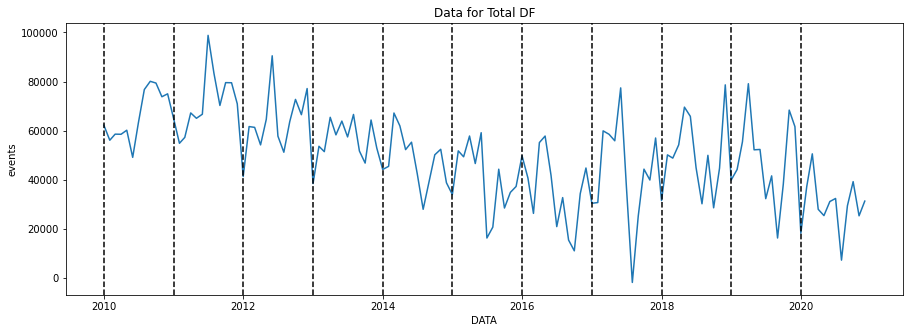

In [62]:
# Showing data for Total DF

plot_df_values(analysis_df, 'Total DF')

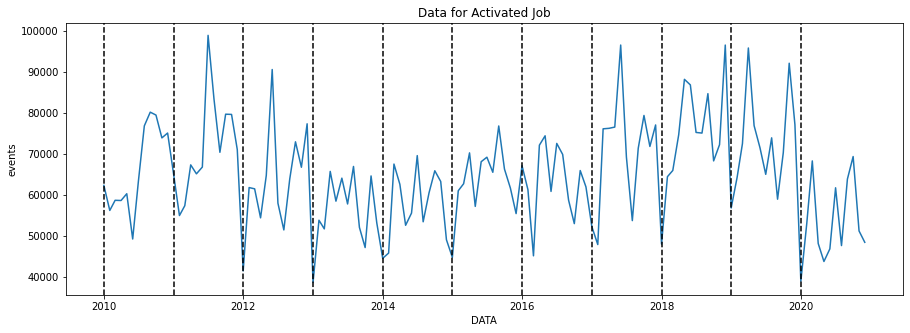

In [63]:
# Showing data for Activated Job

plot_df_values(activated_job, 'Activated Job')

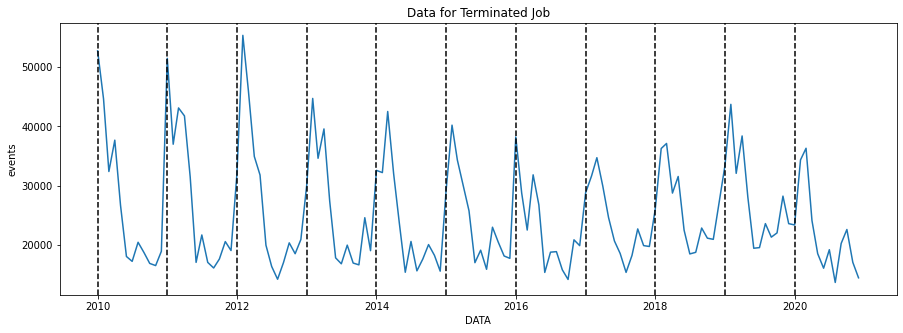

In [64]:
# Showing data for Terminated Job

plot_df_values(terminated_job, 'Terminated Job')

### Showing Autocorrelation Coefficents

In [65]:
# Plotting ACF and PACF of the related data

def find_autocorrelation(temp_df, title):
    
    # DF Manipulation
    df = temp_df.copy()
    df = df[(df['YEAR'] < 2021) & (df['YEAR'] > 2009)]
    df['DATA'] = df['YEAR'].astype(int).astype(str) + '-' + df['MONTH'].astype(int).astype(str) + '-01'
    df['DATA'] = pd.to_datetime(df['DATA'])

    # Creating the subplot
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    fig.set_size_inches(18.5, 10.5)
    
    # Plotting ACF function of the data set
    plot_acf(df.events, lags = 20, ax = ax1)
    
    # Plotting PACF function of the data set
    plot_pacf(df.events, lags = 20, ax = ax2)

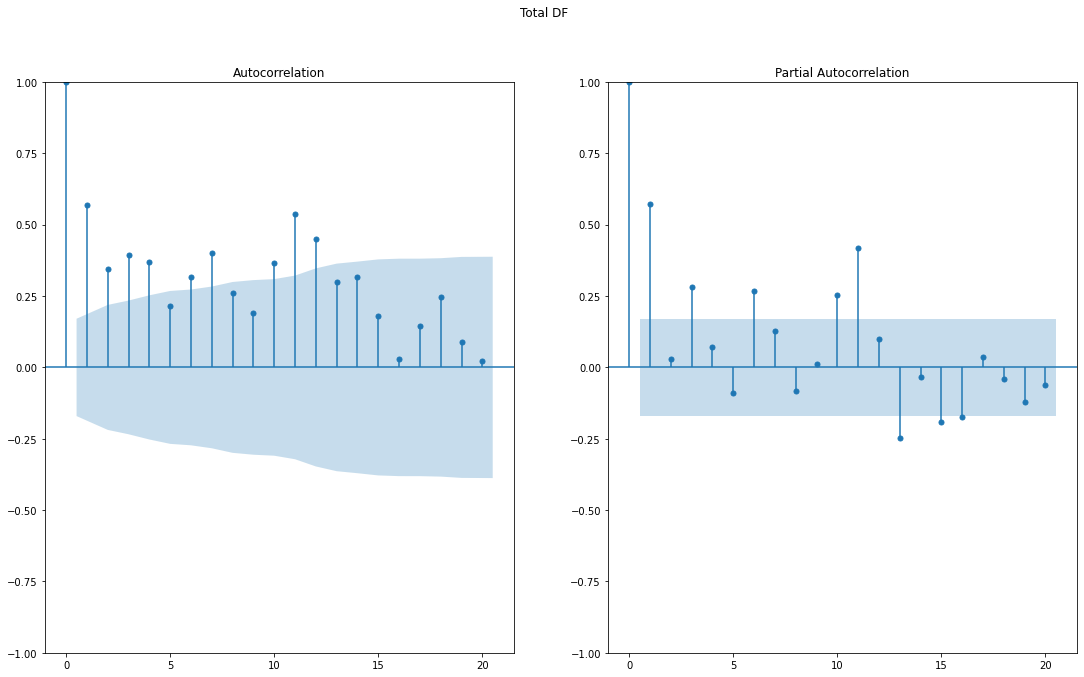

In [66]:
# Computing Autocorrelation Values for Total DF

find_autocorrelation(analysis_df, 'Total DF')

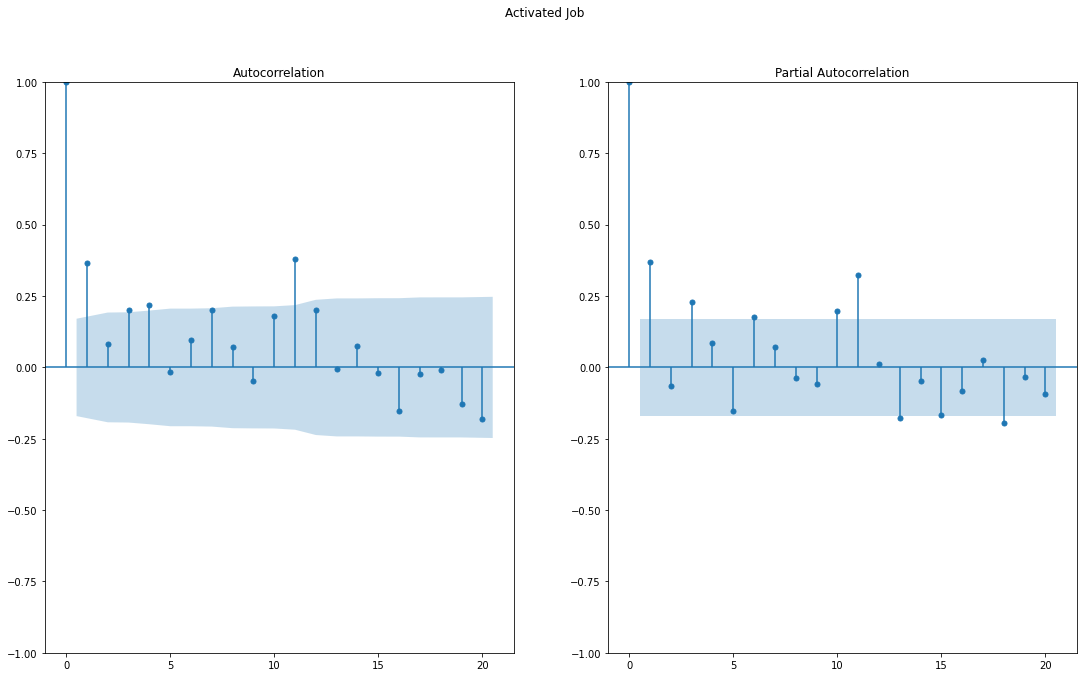

In [67]:
# Computing Autocorrelation Values for Activated Job

find_autocorrelation(activated_job, 'Activated Job')

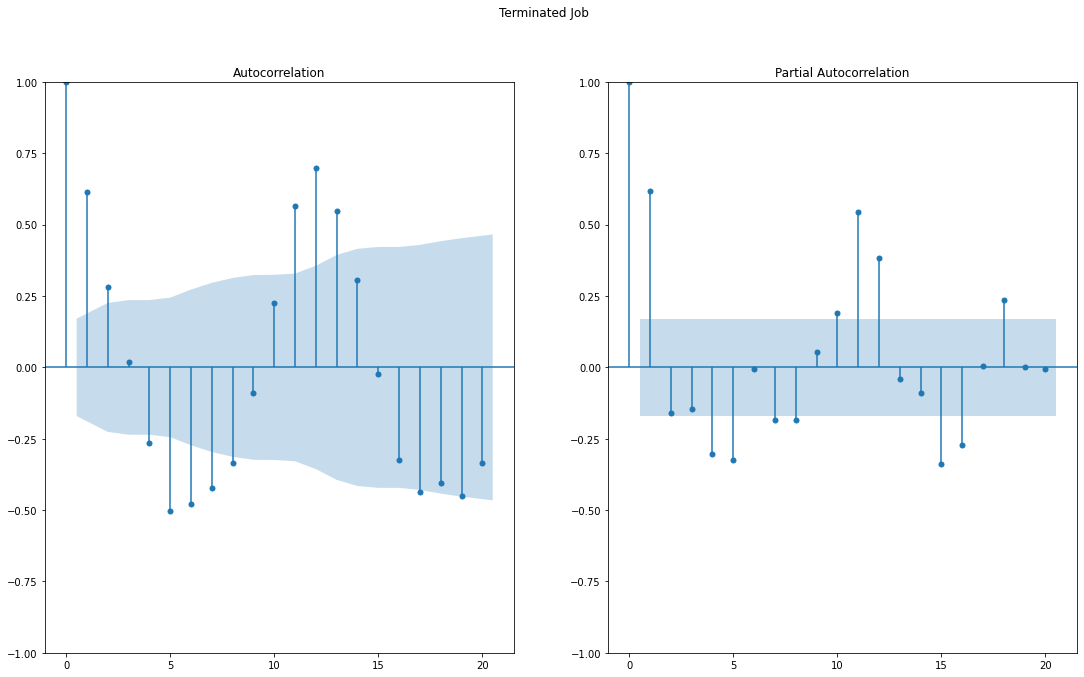

In [68]:
# Computing Autocorrelation Values for Terminated Job

find_autocorrelation(terminated_job, 'Terminated Job')

### Performing the Analysis

In [69]:
# Finding best p and q for the analysis

def findBestComposition(train, test):
    vMax = 3
    ps = []
    qs = []
    vs = []
    best_p = 0
    best_q = 0
    bestValue = None
    history = [x for x in train]
    predictions = []
    
    # Trying p from 0 to 2
    for p in range(vMax):
        # Trying q from 0 to 2
        for q in range(vMax):
            history = [x for x in train]
            predictions = []
            
            # Generating SARIMA model with specific p and q
            for t in range(len(test)):
                model = SARIMAX(history, order=(p,1,q), seasonal_order=(0, 1, 0, 12))
                model_fit = model.fit()
                output = model_fit.forecast()
                yhat = output[0]
                predictions.append(yhat)
                obs = test[t]
                history.append(obs)
                
            # Computing RMSE for the generated Model
            rmse = sqrt(mean_squared_error(test, predictions))
            if bestValue is None or rmse < bestValue:
                bestValue = rmse
                best_p = p
                best_q = q
            ps.append(p)
            qs.append(q)
            vs.append(rmse)
            
    # Creating a df containing RMSE for each p and q composition
    data = pd.DataFrame({'P': ps, 'Q': qs, 'RMSE': vs})
    return data.pivot('P', 'Q', 'RMSE'), bestValue, best_p, best_q

In [70]:
# Creating the model for the specific DF

def generateModel(analysis_df, title):
    
    # DF Manipulation
    df = analysis_df.copy()
    df = df[(df['YEAR'] < 2021) & (df['YEAR'] > 2009)]
    df['DATA'] = df['YEAR'].astype(int).astype(str) + '-' + df['MONTH'].astype(int).astype(str) + '-01'
    df['DATA'] = pd.to_datetime(df['DATA'])
    df.drop(columns = ['YEAR', 'MONTH'], inplace = True)
    df.set_index('DATA', inplace=True)
    
    # Creating Train and Test set
    X = df.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    
    # Finding best p and q
    data_pivoted, rsme, p ,q = findBestComposition(train, test)
    
    history = [x for x in train]
    predictions = []
    
    # Creating SARIMA Model
    for t in range(len(test)):
        model = SARIMAX(history, order=(p,1,q), seasonal_order=(0, 1, 0, 12))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    
    # Computing RMSE with model results
    rmse = sqrt(mean_squared_error(test, predictions))
    
    array = df.index.values
    assex = []
    for i in range(len(df.index)-len(test), len(df.index)):
        assex.append(array[i])
    
    # Plotting Heatmap with p and q composition
    ax = sns.heatmap(data_pivoted, cmap="BuPu")
    ax.set_title('Best RSME:{0} with p:{1} q:{2}'.format(int(rsme), p, q))
    plt.show()
    
    # Plotting real and predicted data
    fig, ax = plt.subplots(figsize=(15,5))
    plt.plot(assex, test, label='Test Data')
    plt.title(title.format(int(rsme), p, q))
    plt.plot(assex, predictions, color='red', label='Predicted Data')
    ax.legend()
    plt.show()
    
    # Predicting Future Data from 2021 to 2022
    start = datetime.strptime("2021-01-01", "%Y-%m-%d")
    date_list = [start + relativedelta(months=x) for x in range(0,12)]
    future = pd.DataFrame(index=date_list, columns= df.columns)
    future['events'] = model_fit.predict(start = 133, end = 144, dynamic= True)
    
    # Ploting Future Data from 2021 to 2022
    fig, ax = plt.subplots(figsize=(15,5))
    chart = sns.lineplot(data = future, palette=['green'])
    chart.set_title('Forcasted Data for '+title)

### Total DF Model

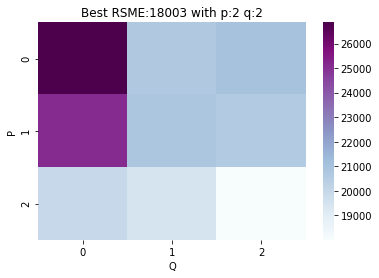

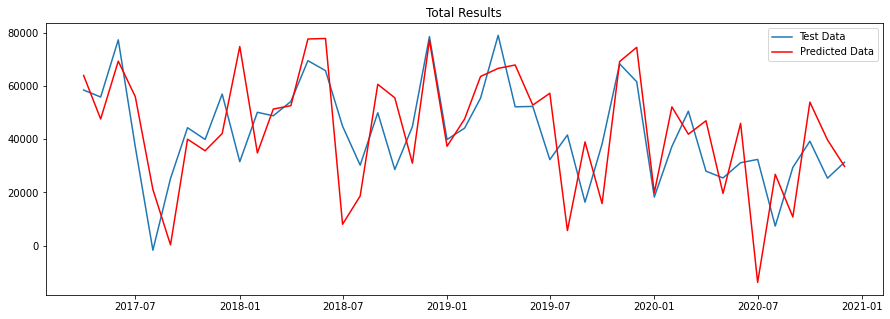

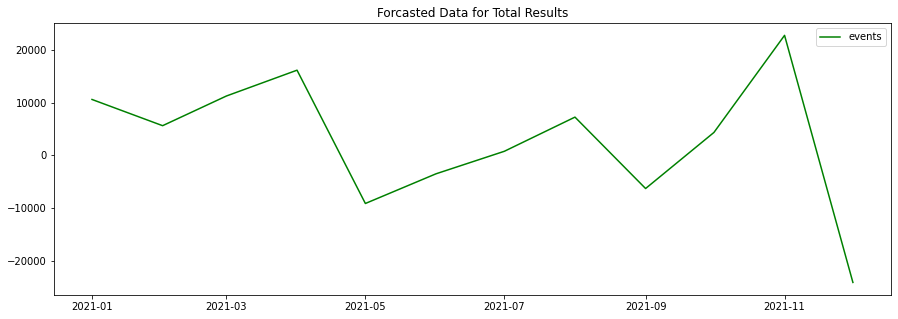

In [71]:
# Generating Model for Total DF

generateModel(analysis_df, 'Total Results')

### Activated Job Model

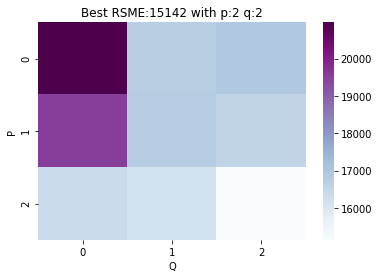

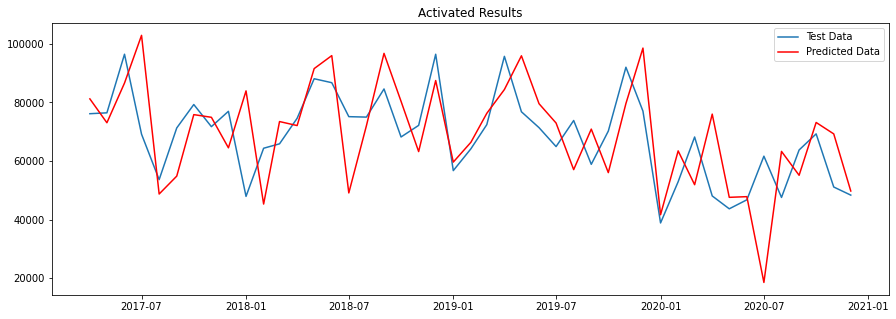

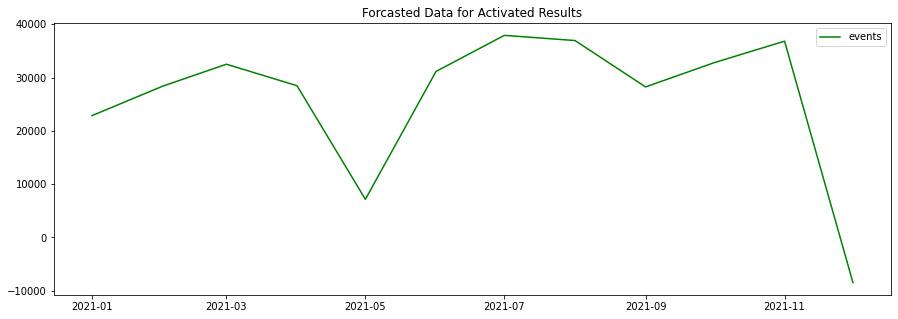

In [72]:
# Generating Model for Activated Job

generateModel(activated_job, 'Activated Results')

### Terminated Job Model

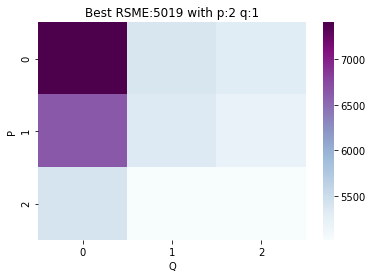

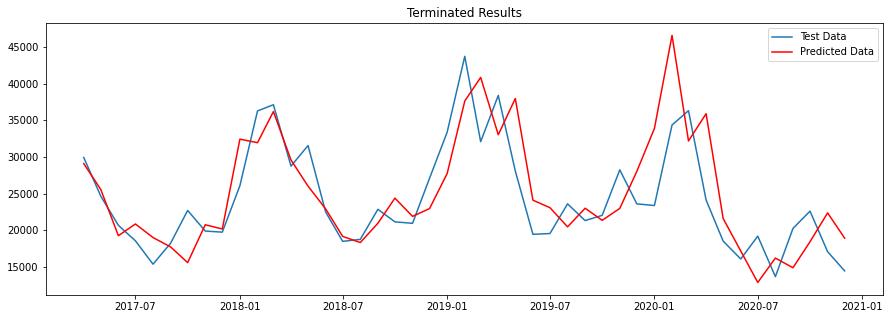

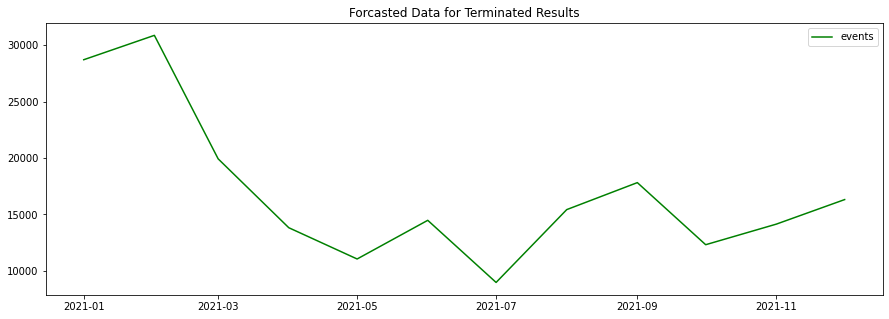

In [73]:
# Generating Model for Terminated Job

generateModel(terminated_job, 'Terminated Results')

## Conclusion

After a first analysis of the two datasets we understood how data was composed and distributed.
Since our main goal was to provide a prevision on future trends of the job market in Lombardy for a specific year and month, we decided keep only the amount of contracts for each month and year.
We analyzed the df in order to decide the time series model. The forecasting was performed using SARIMA, since data where non-stationary and seasonal. The results presented an higher accuracy when we considered just the terminated contracts df (5019 RSME), problably because terminated contracts are more stable over the time than activated ones.


## References

On moving-average models with feedback, DONG LI, SHIQING LING, and HOWELL TONG

Moving averages, Rob J Hyndman

An Introductory Study on Time Series Modeling and Forecasting, Ratnadip Adhikari,R. K. Agrawal